# **Preparation Notebook**



---
## Setup Environment

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36106,
    assignment="AT1",
)
at.run()

import warnings
warnings.simplefilter(action='ignore')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

You can now save your data files in: /content/gdrive/MyDrive/36106/assignment/AT1/data


---
## Student Information

In [ ]:
# <Student to fill this section and then remove this comment>
student_name = "Parisasadat Kalaki"
student_id = "25969686"

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h1", key='student_name', value=student_name)

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h1", key='student_id', value=student_id)

---
## 0. Python Packages

### 0.a Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [ ]:
!pip install --upgrade scikit-learn


  Using cached scikit_learn-1.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
utstd 0.1.8 requires scikit-learn~=1.5.1, but you have scikit-learn 1.7.1 which is incompatible.


### 0.b Import Packages

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
import pandas as pd
import altair as alt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency



---
## A. Feature Selection


In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
# Load training data
try:
  training_df = pd.read_csv(at.folder_path / "car_insurance_premium_training.csv")
  validation_df = pd.read_csv(at.folder_path / "car_insurance_premium_validation.csv")
  testing_df = pd.read_csv(at.folder_path / "car_insurance_premium_testing.csv")
except Exception as e:
  print(e)

### A.1 Approach 1: Pearson Correlation

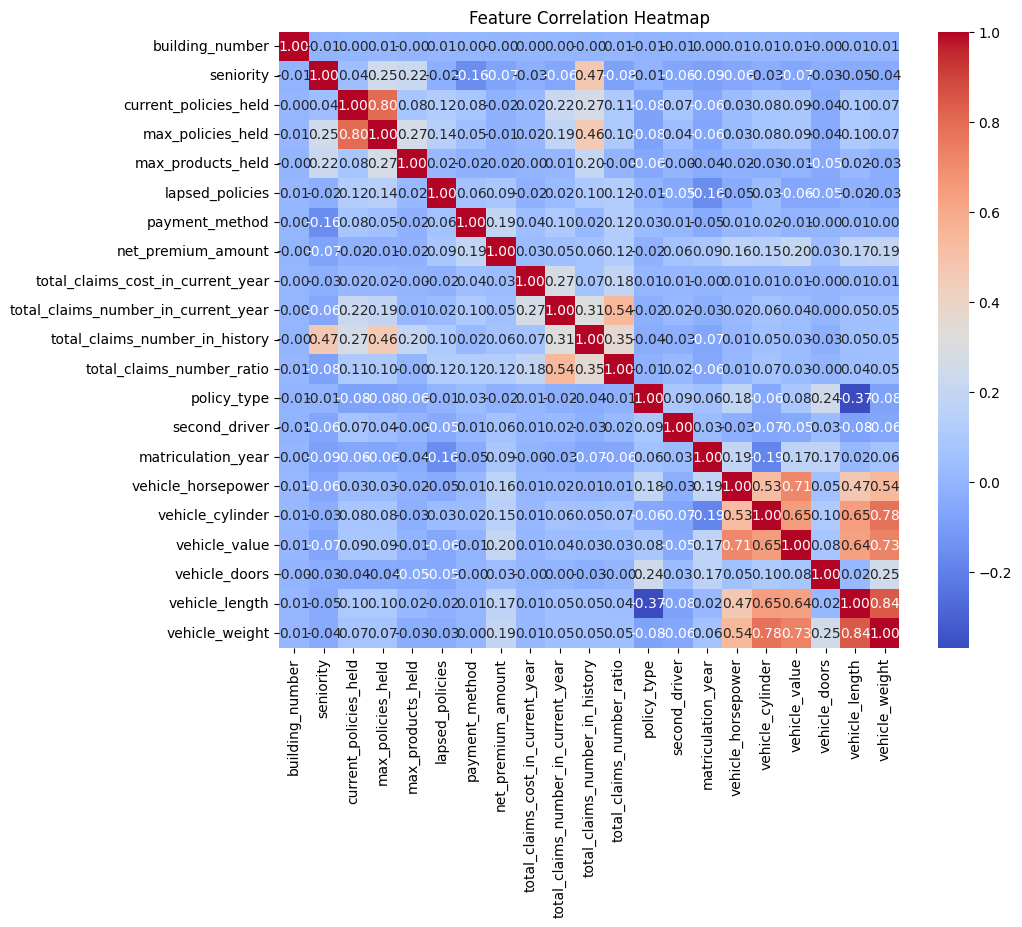

In [ ]:
numeric_df = training_df.select_dtypes(include=["int64", "float64"])

# Compute correlation
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



In [ ]:
drop_columns = [
    'customer_id', 'prefix', 'first_name', 'last_name', 'phone_number', 'email',
    'secondary_address', 'street_name', 'street_suffix', 'suburb', 'building_number'
]

strong_numeric = [
    'vehicle_value', 'vehicle_weight', 'vehicle_length',
    'vehicle_horsepower', 'vehicle_cylinder',
    'matriculation_year'
]

weak_numeric = [
    'seniority', 'current_policies_held',
    'max_products_held', 'lapsed_policies', 'total_claims_cost_in_current_year',
    'total_claims_number_in_current_year', 'total_claims_number_in_history',
    'total_claims_number_ratio', 'vehicle_doors'
]
categorical_features = [
    'gender','distribution_channel', 'policy_type', 'second_driver', 'vehicle_fuel_type'
]
# 'birth_date',
date_columns = [ 'driving_license_date', 'contract_start_date', 'last_renewal_date']

target = ['net_premium_amount']

data_leakage_columns = ['payment_method', 'lapsed_date', 'next_renewal_date', 'contract_start_date']

high_corr_features = [
    'current_policies_held', 'max_policies_held',    # correlation ~0.797
    'vehicle_length', 'vehicle_weight',            # correlation ~0.841
]
# will drop 'max_policies_held' and 'vehicle_length'because of multicolinearity

In [ ]:
feature_selection_1_insights = """
Numeric Features & Correlation Analysis

Computed correlation between numeric features and the target (net_premium_amount).

building_number has very low correlation (~0.000) → unlikely to provide predictive power → dropped.

Strongly correlated features (more likely informative):
vehicle_value, vehicle_weight, vehicle_length, vehicle_horsepower, vehicle_cylinder, payment_method, matriculation_year.

Weakly correlated features (less predictive individually but may help in some models):
seniority, current_policies_held, max_policies_held, max_products_held, lapsed_policies, total_claims_cost_in_current_year, total_claims_number_in_current_year, total_claims_number_in_history, total_claims_number_ratio, vehicle_doors.

Organized numeric features into strong and weak lists for experimentation.

In future modeling, plan to compare using all numeric features vs only the strong ones.

Multicollinearity

Some numeric features show high correlation with each other → potential multicollinearity:

current_policies_held ↔ max_policies_held (~0.797)

vehicle_value ↔ vehicle_horsepower (~0.713)

vehicle_value ↔ vehicle_cylinder (~0.647)

vehicle_length ↔ vehicle_weight (~0.841)

Date Features

Features: birth_date, driving_license_date, contract_start_date, last_renewal_date, next_renewal_date, lapsed_date.

Will be formatted and converted to numeric values (e.g., years since the date) for modeling.

Categorical Features

Features: gender, policy_type, vehicle_fuel_type, second_driver, distribution_channel.

Cannot be analyzed via correlation.

Plan to perform chi-square tests (after binning net_premium_amount) to determine which are informative.

"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### A.2 Approach 2: Chi-square test

In [ ]:
# Make a copy of the training data
train_df_copy = training_df.copy()

# Now make changes on the copy
df = train_df_copy

# Example: bin the target variable on the copy
df['net_premium_bin'] = pd.qcut(df['net_premium_amount'], q=4, labels=False)

# Perform chi-square test
chi2_results = {}

for col in categorical_features:
    contingency_table = pd.crosstab(df[col], df['net_premium_bin'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[col] = p  # store the p-value

# Convert results to DataFrame for readability
chi2_results_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'p_value'])
chi2_results_df.sort_values('p_value', inplace=True)
print(chi2_results_df)

strong_categorical = ["distribution_channel", "vehicle_fuel_type", "policy_type", "second_driver"]



                Feature       p_value
1  distribution_channel  6.998195e-84
4     vehicle_fuel_type  1.843310e-53
2           policy_type  4.780171e-42
3         second_driver  5.277636e-26
0                gender  5.594375e-01


In [ ]:
feature_selection_2_insights = """
distribution_channel, vehicle_fuel_type, policy_type, and second_driver all showed extremely low p-values (≪ 0.05), meaning they are strongly associated with the target and are informative features to keep.

gender had a high p-value (0.56), meaning there’s no significant association with the target.
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### A.z Final Selection of Features

In [ ]:
# <Student to fill this section and then remove this comment>

features_list = ['vehicle_value', 'vehicle_weight', 'vehicle_horsepower',
       'vehicle_cylinder', 'matriculation_year', 'seniority',
       'current_policies_held', 'max_products_held',
       'lapsed_policies', 'total_claims_cost_in_current_year',
       'total_claims_number_in_current_year', 'total_claims_number_in_history',
       'total_claims_number_ratio', 'vehicle_doors', 'distribution_channel',
       'vehicle_fuel_type', 'policy_type', 'second_driver','last_renewal_date','driving_license_date']
print("Total features:", len(features_list))

Total features: 20


In [ ]:
feature_selection_explanations = """
For the modeling, features that could cause data leakage or reveal future outcomes, such as payment_method, lapsed_date, and next_renewal_date, contract_start_date, were removed, as this information would not be available at prediction time. Max_policies_held and vehicle_length were removed because of multicollinearity. Additionally, to address ethical considerations and reduce potential bias, gender and age were excluded from the model. Other features with low predictive value, high missingness, or potential privacy concerns, such as vehicle_length, max_policies_held, customer_id, prefix, first_name, last_name, birth_date, phone_number, email, and address-related fields, were also dropped. The remaining features were retained for modeling, ensuring both predictive relevance and ethical responsibility. net_premium_amount was the target variable.
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## B. Data Cleaning

In [ ]:
training_df.columns

Index(['customer_id', 'prefix', 'first_name', 'last_name', 'gender',
       'birth_date', 'driving_license_date', 'phone_number', 'email',
       'secondary_address', 'building_number', 'street_name', 'street_suffix',
       'suburb', 'contract_start_date', 'last_renewal_date',
       'next_renewal_date', 'distribution_channel', 'seniority',
       'current_policies_held', 'max_policies_held', 'max_products_held',
       'lapsed_policies', 'lapsed_date', 'payment_method',
       'net_premium_amount', 'total_claims_cost_in_current_year',
       'total_claims_number_in_current_year', 'total_claims_number_in_history',
       'total_claims_number_ratio', 'policy_type', 'second_driver',
       'matriculation_year', 'vehicle_horsepower', 'vehicle_cylinder',
       'vehicle_value', 'vehicle_doors', 'vehicle_fuel_type', 'vehicle_length',
       'vehicle_weight'],
      dtype='object')

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
# Create copy of datasets
try:
  training_df_clean = training_df[features_list].copy()
  validation_df_clean = validation_df[features_list].copy()
  testing_df_clean = testing_df[features_list].copy()
except Exception as e:
  print(e)

### B.1 Fixing "Missing values in vehicle_fuel_type"

In [ ]:
training_df_clean['vehicle_fuel_type'].value_counts(dropna=False)


,count
vehicle_fuel_type,
D,21450
P,10608
NaN,78


In [ ]:
vehicle_features = [
    'policy_type', 'vehicle_horsepower', 'vehicle_cylinder', 'vehicle_value',
    'vehicle_doors', 'vehicle_weight', 'second_driver', 'matriculation_year'
]

missing_fuel_df = training_df_clean[training_df_clean['vehicle_fuel_type'].isna()][vehicle_features]

# Print distinct values for each column
for col in vehicle_features:
    print(f"{col} distinct values:")
    print(missing_fuel_df[col].unique())
    print("-" * 40)


policy_type distinct values:
[1]
----------------------------------------
vehicle_horsepower distinct values:
[0]
----------------------------------------
vehicle_cylinder distinct values:
[1170   49   50  124  530  499 1584  249  599  248  125  806  998  385
  656  250  999  821  486  652  649  781]
----------------------------------------
vehicle_value distinct values:
[14200.    1899.    3005.    2380.    2499.   10849.    2149.   10499.
  2139.   23600.    1299.    2299.    3880.    1051.45  1999.    9321.1
  1778.39  1549.   10280.    4134.96  1501.93  4499.    2659.    2258.
  3399.    2518.24  7350.   14319.   10399.    6899.   13799.    2730.
 10397.    2516.    3099.    6399.    3425.    2559.    2999.    1719.
 14350.    7146.    3020.   10740.    3701.    4599.    4799.    7221.
  2732.    7300.   10511.7   6600.    2619.    2554.    2459.    4299.
 14399.    3825.    2440.    7250.    3769.     661.11  2804.  ]
----------------------------------------
vehicle_doors distinct

In [ ]:
# Filter rows that are motorbikes and have a recorded fuel type
non_motorbike_fuel = training_df_clean[
    (training_df_clean['policy_type'] == 1) &
    (training_df_clean['vehicle_fuel_type'].notna())
]['vehicle_fuel_type']

# Show counts of each fuel type
print(non_motorbike_fuel.value_counts())


vehicle_fuel_type
P    279
D      3
Name: count, dtype: int64


In [ ]:
# Replace NaN fuel type for motorbikes with 'P'
training_df_clean.loc[
    (training_df_clean['vehicle_fuel_type'].isna()),
    'vehicle_fuel_type'
] = 'P'

# Replace NaN fuel type for motorbikes with 'P'
validation_df_clean.loc[
    (validation_df_clean['vehicle_fuel_type'].isna()),
    'vehicle_fuel_type'
] = 'P'

# Replace NaN fuel type for motorbikes with 'P'
testing_df_clean.loc[
    (testing_df_clean['vehicle_fuel_type'].isna()),
    'vehicle_fuel_type'
] = 'P'


In [ ]:
# <Student to fill this section and then remove this comment>
data_cleaning_2_explanations = """
The NaN values in vehicle_fuel_type all correspond to policy_type = 1, which are motorbikes. I also noticed that among the motorbikes that do have a recorded fuel type, most are petrol (P = 279, D = 3). Therefore, I decided to replace the NaN values in vehicle_fuel_type for motorbikes with "P".
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### B.2 Fixing "Invalid values in distrubution_channel"

In [ ]:
training_df_clean['distribution_channel'].value_counts()

,count
distribution_channel,
0,15662
1,15535
00/01/1900,939


In [ ]:
# Compute mode of the column excluding the placeholder
mode_value = training_df_clean.loc[training_df_clean['distribution_channel'] != '00/01/1900', 'distribution_channel'].mode()[0]

# Replace placeholder with mode
training_df_clean['distribution_channel'] = training_df_clean['distribution_channel'].replace('00/01/1900', mode_value)
validation_df_clean['distribution_channel'] = validation_df_clean['distribution_channel'].replace('00/01/1900', mode_value)
testing_df_clean['distribution_channel'] = testing_df_clean['distribution_channel'].replace('00/01/1900', mode_value)


In [ ]:
data_cleaning_3_explanations = """
Replacing the placeholder values in distribution_channel with the mode corrects invalid entries and prevents the model from learning from noise. It preserves the feature’s distribution and ensures consistency across training, validation, and test sets, improving model reliability and generalization."""""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### B.3 Fixing "Invalid values in horse_power"

In [ ]:
training_df_clean['vehicle_horsepower'].value_counts()

,count
vehicle_horsepower,
90,4286
110,2669
100,2417
75,2316
105,1775
...,...
208,1
290,1
32,1


In [ ]:
# Count how many rows have'vehicle_horsepower' = 0
low_value_count = training_df[training_df['vehicle_horsepower'] == 0].shape[0]
print("Number of rows with 'vehicle_horsepower' = 0:", low_value_count)

# See the premium statistics for these rows
low_value_summary = training_df[training_df['vehicle_horsepower'] == 0]['net_premium_amount'].describe()
print(low_value_summary)

Number of rows with 'vehicle_horsepower' = 0: 78
count     78.000000
mean     556.500000
std       39.823882
min      465.000000
25%      526.250000
50%      549.500000
75%      579.000000
max      670.000000
Name: net_premium_amount, dtype: float64


In [ ]:
# Select rows where vehicle_horsepower is 0
vehicle_hp_zero = training_df_clean[training_df_clean['vehicle_horsepower']==0]

# Check missing values in other vehicle features for these rows
vehicle_features = [
     'vehicle_cylinder', 'vehicle_value','policy_type',
    'vehicle_doors', 'vehicle_fuel_type', 'vehicle_weight'
]

for col in vehicle_features:
    distinct_vals = vehicle_hp_zero[col].unique()
    print(f"{col} distinct values:\n{distinct_vals}\n{'-'*40}")



vehicle_cylinder distinct values:
[1170   49   50  124  530  499 1584  249  599  248  125  806  998  385
  656  250  999  821  486  652  649  781]
----------------------------------------
vehicle_value distinct values:
[14200.    1899.    3005.    2380.    2499.   10849.    2149.   10499.
  2139.   23600.    1299.    2299.    3880.    1051.45  1999.    9321.1
  1778.39  1549.   10280.    4134.96  1501.93  4499.    2659.    2258.
  3399.    2518.24  7350.   14319.   10399.    6899.   13799.    2730.
 10397.    2516.    3099.    6399.    3425.    2559.    2999.    1719.
 14350.    7146.    3020.   10740.    3701.    4599.    4799.    7221.
  2732.    7300.   10511.7   6600.    2619.    2554.    2459.    4299.
 14399.    3825.    2440.    7250.    3769.     661.11  2804.  ]
----------------------------------------
policy_type distinct values:
[1]
----------------------------------------
vehicle_doors distinct values:
[0]
----------------------------------------
vehicle_fuel_type distinct 

In [ ]:
# Calculate the median horsepower ignoring zeros
median_hp_policy1 = training_df.loc[
    (training_df['vehicle_horsepower'] != 0) &
    (training_df['policy_type'] == 1),
    'vehicle_horsepower'
].median()
print("Median horsepower (excluding zeros):", median_hp_policy1)

# Replace 0 horsepower with the median
training_df['vehicle_horsepower'] = training_df['vehicle_horsepower'].replace(0, median_hp_policy1)

# Check if any zeros remain
print("Remaining rows with 0 horsepower:", (training_df['vehicle_horsepower'] == 0).sum())


Median horsepower (excluding zeros): 46.5
Remaining rows with 0 horsepower: 0


In [ ]:
data_cleaning_3_explanations = """
There were 78 records with horsepower = 0, all of them belonging to motorbikes (policy_type = 1). Since a horsepower of zero is not realistic, these values were treated as missing and replaced with the median horsepower of motorbikes to ensure data consistency.
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

---
## C. Feature Engineering

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
# Create copy of datasets

try:
  training_df_eng = training_df_clean.copy()
  validation_df_eng = validation_df_clean.copy()
  testing_df_eng = testing_df_clean.copy()
except Exception as e:
  print(e)

### C.1 New Feature "driving_experience_years"



In [ ]:
# Convert all relevant columns to datetime
date_columns = ['last_renewal_date','driving_license_date']
for dataset in [training_df_eng, validation_df_eng, testing_df_eng]:
    for col in date_columns:
        dataset[col] = pd.to_datetime(dataset[col], errors='coerce')

In [ ]:
# Calculate driving experience in years
today = pd.Timestamp.today()
training_df_eng['driving_experience_years'] = (today - training_df_eng['driving_license_date']).dt.days // 365
validation_df_eng['driving_experience_years'] = (today - validation_df_eng['driving_license_date']).dt.days // 365
testing_df_eng['driving_experience_years'] = (today - testing_df_eng['driving_license_date']).dt.days // 365

# drop driving_license_date
training_df_eng.drop('driving_license_date', axis=1, inplace=True)
validation_df_eng.drop('driving_license_date', axis=1, inplace=True)
testing_df_eng.drop('driving_license_date', axis=1, inplace=True)


In [ ]:
# <Student to fill this section and then remove this comment>
feature_engineering_2_explanations = """
The driving_experience_years feature represents the number of years a person has held their driving license, calculated as the difference between today and the driving_license_date. It transforms raw dates into a continuous, interpretable metric that reflects practical driving experience, allowing easy comparisons between individuals. This feature is useful for analysis and modeling because it often correlates with driving behavior, accident risk, and insurance considerations, and it can also be combined with other features—like age—to derive insights such as the age at which someone obtained their license.
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### C.2 Fixing "years_since_last_renewal"

> You can add more cells related to new features in this section

In [ ]:
training_df_eng['years_since_last_renewal'] = ((today - training_df_eng['last_renewal_date']).dt.days // 365)
validation_df_eng['years_since_last_renewal'] = ((today - validation_df_eng['last_renewal_date']).dt.days // 365)
testing_df_eng['years_since_last_renewal'] = ((today - testing_df_eng['last_renewal_date']).dt.days // 365)

# drop last_renewal_date
training_df_eng.drop('last_renewal_date', axis=1, inplace=True)
validation_df_eng.drop('last_renewal_date', axis=1, inplace=True)
testing_df_eng.drop('last_renewal_date', axis=1, inplace=True)


In [ ]:
# <Student to fill this section and then remove this comment>
feature_engineering_4_explanations = """
raw dates like last_renewal_date are not directly useful for modeling. By transforming them into a numeric feature, you capture the elapsed time since the last contract renewal, which reflects how recently the policyholder engaged with their policy. This information is important because longer gaps since renewal often signal a higher risk of churn, lower engagement, or reduced likelihood of renewing again, making it a strong predictor in tasks such as churn modeling, customer retention analysis, or renewal forecasting.
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_4_explanations)

---
## D. Data Preparation for Modeling

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
# Create copy of datasets
target_name = 'net_premium_amount'

try:
  X_train = training_df_eng.copy()
  X_val = validation_df_eng.copy()
  X_test = testing_df_eng.copy()

  y_train = X_train.pop(target_name)
  y_val = X_val.pop(target_name)
  y_test = X_test.pop(target_name)
except Exception as e:
  print(e)

'net_premium_amount'


### D.1 Data Transformation vehicle_fuel_type


In [ ]:
X_train['vehicle_fuel_type']

,vehicle_fuel_type
0,P
1,P
2,P
3,D
4,D
...,...
32131,P
32132,D
32133,P
32134,D


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_train['vehicle_fuel_type'] = le.fit_transform(X_train['vehicle_fuel_type'])
X_val['vehicle_fuel_type'] = le.transform(X_val['vehicle_fuel_type'])
X_test['vehicle_fuel_type'] = le.transform(X_test['vehicle_fuel_type'])


In [ ]:
# <Student to fill this section and then remove this comment>
data_transformation_1_explanations = """
Encoding vehicle_fuel_type is important because most machine learning models cannot directly interpret categorical strings like 'P' or 'D'.
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### D.2 Data Transformation distribution_channel


In [ ]:
# Convert to integer
X_train['distribution_channel'] = X_train['distribution_channel'].astype(int)
X_val['distribution_channel'] = X_val['distribution_channel'].astype(int)
X_test['distribution_channel'] = X_test['distribution_channel'].astype(int)


In [ ]:
data_transformation_1_explanations = """
transforming distribution_channel is important because most machine learning models cannot directly interpret object values.
"""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### D.3 Data Transformation scaling


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val   = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


In [ ]:
data_transformation_1_explanations = """
since I want to use linear models, I need to scale all features."""

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## E. Save Datasets

> Do not change this code

In [ ]:
# DO NOT MODIFY THE CODE IN THIS CELL

try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

name 'y_train' is not defined
